In [1]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:508: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-7.07 or later is installed on your system
  'installed on your system') % gs_req)


In [2]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 100000
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*2 - 1
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.001,0,0],[0,.001,0],[0,0,.001]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


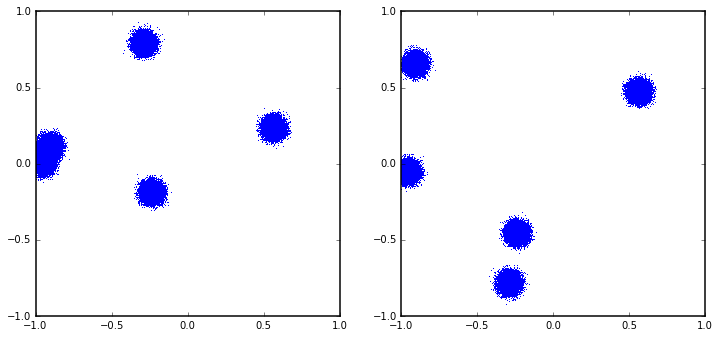

In [3]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
axs[0].plot(particles['pos'][:,0], particles['pos'][:,1], ',')
axs[1].plot(particles['pos'][:,0], particles['pos'][:,2], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [10]:
%time fof.run(particles, 0.01)

CPU times: user 298 ms, sys: 1.98 ms, total: 300 ms
Wall time: 304 ms


15

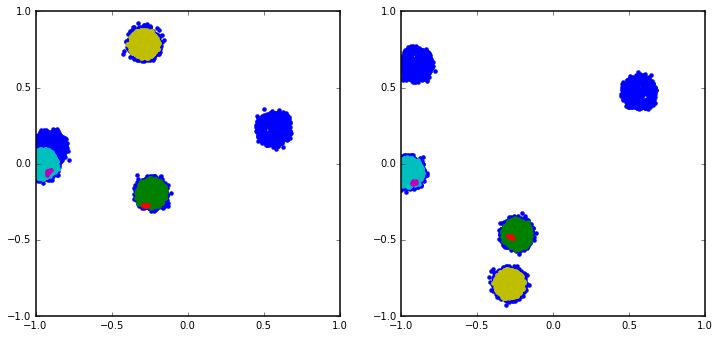

In [11]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in range(ngs+1): 
    inds = np.where(particles['iGroup'] == group)[0]
    axs[0].plot(particles['pos'][inds,0], particles['pos'][inds,1], '.')
    axs[1].plot(particles['pos'][inds,0], particles['pos'][inds,2], '.')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)